In [1]:
import pandas as pd
import numpy as np
import feature_engine 
import pickle
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
ENCODED_DATA_PATH = '../data/processed/1_encoded_df.pkl'
TARGET_COL = 'DevType'
CLUSTERED_DF_PATH = '../data/processed/1_clustered_skills_df.pkl'
SKILLS_CLUSTERS_PATH = '../data/processed/skills_clusters.json'


In [3]:
df = pd.read_pickle(ENCODED_DATA_PATH)
df.head()

LanguageHaveWorkedWith                                                      \
                     APL Assembly Bash/Shell  C C# C++ COBOL Clojure Crystal   
0                      0        0          0  0  0   1     0       0       0   
1                      0        0          0  0  0   0     0       0       0   
2                      0        1          0  1  0   0     0       0       0   
3                      0        0          0  0  0   0     0       0       0   
4                      0        0          1  0  0   0     0       0       0   

        ...        DevType                                                 \
  Dart  ... Engineer, data Engineer, site reliability Engineering manager   
0    0  ...              0                          0                   0   
1    0  ...              0                          0                   0   
2    0  ...              0                          0                   0   
3    0  ...              0                          0                   0   
4    0  ...              1                          0                   0   

                                                                           \
  Marketing or sales professional Other (please specify): Product manager   
0                               0                       0               0   
1                               0                       0               0   
2                               0                       0               0   
3                               0                       0               0   
4                               0                       1               0   

                                                                               
  Scientist Senior Executive (C-Suite, VP, etc.) Student System administrator  
0         0                                    0       0                    0  
1         0                                    0       0                    0  
2         0                                    0       0                    0  
3         0                                    0       0                    0  
4         0                                    0       0                    0  

[5 rows x 150 columns]

### Skills Associations -> Clustering

In [4]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
skill_groups = set([ group  for group,col in df.drop('DevType',axis=1).columns ])
skills_df = pd.concat([ df.loc[:,group]  for group in skill_groups ],axis=1)


In [5]:

tsne = TSNE(n_components=2,
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=-1, 
                       n_iter=10**10,
                        random_state=42)
reduced_data = tsne.fit_transform(skills_df.T)


c:\Users\Abdelhakiem\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [6]:
reduced_data = pd.DataFrame(reduced_data, index=skills_df.columns)
reduced_data

,0,1
.NET Core / .NET 5,9.517993,26.971794
.NET Framework,10.917777,27.242283
Apache Spark,-8.155976,-10.693071
Cordova,6.916478,3.026538
Flutter,-21.705177,0.686302
...,...,...
Vim,-10.837936,-5.781011
Visual Studio,11.293770,29.453857
Visual Studio Code,29.818184,7.318961
Webstorm,4.107787,1.502153


In [7]:
fig = px.scatter(x=reduced_data.iloc[:, 0],
                 y=reduced_data.iloc[:, 1],
                 text=reduced_data.index.to_list())
fig.update_layout(
    title="t-SNE visualization of Skills",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

We observe that skills can be clustered. We can reduce number of features by grouping skills together.

But what is the suitable number of clusters?

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
plt.figure(figsize=(6, 5))
n_clusters = range(10, 27)
scores=[]
best_clustering_model = None
for i in n_clusters:
    agg_clust = AgglomerativeClustering(n_clusters=i, linkage='ward')
    labels = agg_clust.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, labels)
    scores.append(score)
    if score >= np.max(scores) :
        best_clustering_model = agg_clust

<Figure size 600x500 with 0 Axes>

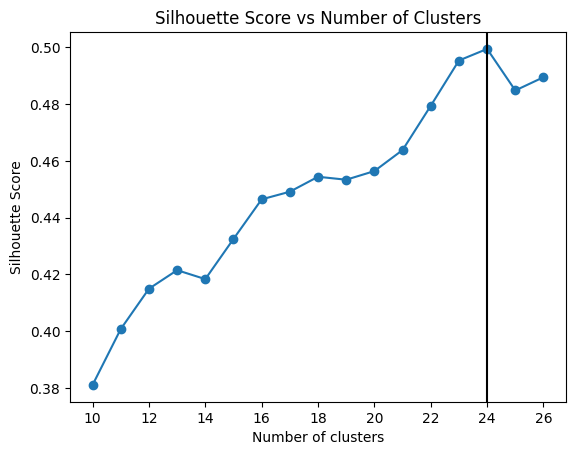

In [9]:
plt.plot(n_clusters, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.axvline(best_clustering_model.n_clusters_,color='black')
plt.show()

In [10]:
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_clustering_model.labels_]

In [11]:
fig = px.scatter(x=reduced_data.iloc[:, 0],
                 y=reduced_data.iloc[:, 1],
                 text=reduced_data.index.to_list(),
                 color = cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [12]:
skills_clusters = reduced_data.index.to_series().groupby(cluster_labels).apply(list)
skills_clusters

skills_group_0     [Qt, APL, COBOL, Clojure, Crystal, Delphi, Gro...
skills_group_1     [Cordova, Drupal, F#, PowerShell, Scala, IBM C...
skills_group_10    [.NET Core / .NET 5, .NET Framework, ASP.NET, ...
skills_group_11    [Flutter, Dart, Kotlin, Google Cloud Platform,...
skills_group_12                          [Objective-C, Swift, Xcode]
skills_group_13                   [Laravel, jQuery, PHP, SQL, MySQL]
skills_group_14                             [Spring, Java, IntelliJ]
skills_group_15                                         [R, RStudio]
skills_group_16                       [Assembly, Bash/Shell, C, C++]
skills_group_17      [HTML/CSS, JavaScript, Git, Visual Studio Code]
skills_group_18                    [Heroku, Ansible, Chef, RubyMine]
skills_group_19                            [FastAPI, Flask, PyCharm]
skills_group_2     [Svelte, Vue.js, Rust, Cassandra, Couchbase, D...
skills_group_20                    [Angular, Angular.js, TypeScript]
skills_group_21                   

Exporting Skills Clusters

In [13]:
# Save the clusters to a json file
skills_clusters.to_json(SKILLS_CLUSTERS_PATH)

### Create Dataframe with clustered features

In [14]:
dfs = {}
for cluster, skills in skills_clusters.items():
    dfs[cluster] = skills_df.loc[:,skills].sum(axis=1)

In [15]:
clustered_skills_df = pd.concat([pd.DataFrame(dfs),df.loc[:,'DevType']],axis=1)

### Export DF

In [16]:
clustered_skills_df.to_pickle(CLUSTERED_DF_PATH)